# Celestial Mechanics - Homework 5
## Giacomo Menegatti - 2122852

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial as fac
import matplotlib.cm as cmaps


## Stumff's functions
The general form of a Stumff's function is $$c_n(z)=\sum_{k=0}^\infty (-1)^k\frac{z^k}{(2k+n)!} $$ that far from zero can be derived from a combination of trigonometric functions in the positive domain and hyperbolic ones in the negative part. Around zero, to avoid errors in the computation, the series expansion is used. 

The first derivative is found applying the recursive relation $$ c'_{n}(z)=\frac{n}{2}c_{n+2}(z)-\frac{1}{2}c_{n+1}(z) $$

After studying where the computation starts to get unstable, I chosed $|z|<10^{-2}$ as a treshold for switching to the series, and considering that the precision is up to 15 digits in Python doubles, an expansion to $z^8$ is required.

In [116]:
pos_func = [lambda x: np.cos(x), lambda x: np.sin(x)/x, lambda x: (1-np.cos(x))/x**2, lambda x: (x-np.sin(x))/x**3, lambda x: (np.cos(x)-1+x**2/2)/x**4, lambda x: (np.sin(x)-x+x**3/6)/x**5]

neg_func = [lambda x: np.cosh(x), lambda x: np.sinh(x)/x, lambda x: (np.cosh(x)-1)/x**2, lambda x: (np.sinh(x)-x)/x**3, lambda x: (np.cosh(x)-1-x**2/2)/x**4, lambda x: (np.sinh(x)-x-x**3/6)/x**5]

def c(z, n=0):
  if np.fabs(z)<1e-2:
    return sum((-z)**k/fac(2*k+n) for k in range(0, 8))
  elif z>0:
    return pos_func[n]((z)**0.5)
  else:
    return neg_func[n]((-z)**0.5)

def c_prime(z, n=0):
  return n/2*c(z, n=n+2)-172*c(z, n=n+1)


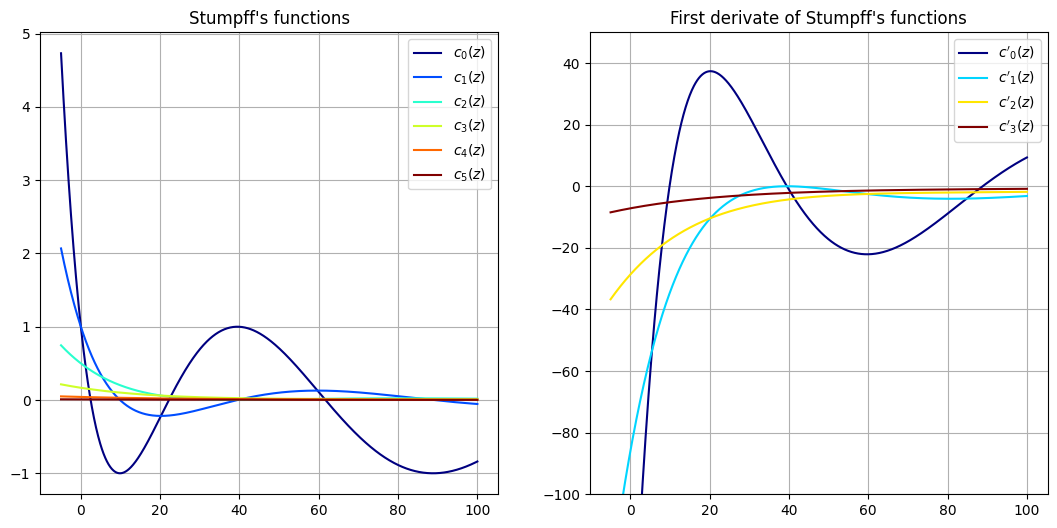

In [117]:
x = np.linspace(-5, 100, 1000)

fig, AX = plt.subplots(nrows=1, ncols=2, figsize=(13,6))

AX[0].set_title("Stumpff's functions")
for n, col in zip(range(0,6), cmaps.jet(np.linspace(0,1,6))):
  AX[0].plot(x, [c(z, n=n) for z in x], color=col,  label =f'$c_{n}(z)$')
AX[0].legend()
AX[0].grid()

AX[1].set_title("First derivate of Stumpff's functions")
for n, col in zip(range(0,4), cmaps.jet(np.linspace(0,1,4))):
  AX[1].plot(x, [c_prime(z, n=n) for z in x], color=col,  label =f"$c'_{n}(z)$")
AX[1].set_ylim([-100,50])
AX[1].legend()
AX[1].grid()


## Universal Kepler's equation solver
The universal Kepler equation is $$ t(s)-t_0=r_0s + r_0 \dot r_0s^2 c_2(-2Cs^2)+(\mu+2r_0C)s^3c_3(-2Cs^2) $$ 
Implementing the Newton-Raphson's method gives $$ s_{n+1} = s_n +  \frac{\Delta t −[t(s_n) − t_0]}{r(s_n)} $$ as the recursive approximation, with starting point $s_0=0$ and the radius is expressed as $$ r(s) = r_0c_0
(−2Cs^2) + r_0 \dot r_0 s c_1(−2Cs^2) + \mu s^2c_2(−2Cs^2) $$

In [118]:
def t_(s, t0, r0, dr0, C, mu):
  '''Time from t0 as a function of s'''
  z = -2*C*s**2
  return t0 + r0*s+r0*dr0*s**2*c(z, n=2)+ (mu+2*r0*C)*s**3*c(z, n=3)

def r_(s, r0, dr0, C, mu):
  '''Radius as a function of s'''
  z = -2*C*s**2
  return r0*c(z, n=0) + r0*dr0*s*c(z, n=1) + mu*s**2*c(z, n=2)

def UKE_solve(t, t0, r0, dr0, C, mu, rtol=1e-10):
  s = 0
  delta_rel = 1
  while delta_rel>rtol:
    delta = (t-t_(s, t0, r0, dr0, C, mu))/r_(s, r0, dr0, C, mu)
    s = s + delta
    delta_rel = delta/s #Relative change in s
  return s


## Venus Flyby 
The position and velocity at a given parameter $s$ are given by the universal Lagrange coefficients matrix
$$ \begin{pmatrix} \mathbf r \\ \mathbf{ \dot r} \end{pmatrix} = \begin{pmatrix} F & G \\ \dot F & \dot G \end{pmatrix} \begin{pmatrix} \mathbf r_0 \\ \mathbf{ \dot r}_0 \end{pmatrix} $$
 with

$$ F = 1 − \frac{\mu}{r_0}s^2c_2(−2Cs^2) $$
$$ G = r_0s c_1(−2Cs^2) + r_0 \dot r_0 s^2c_2(−2Cs^2) $$
$$ \dot F = − \frac{μ}{r(s)r_0}s c_1(−2Cs^2) $$
$$ \dot G = \frac{r_0}{r(s)}c_0(-2Cs^2) + \frac{r_0 \dot r_0}{r(s)}sc_1(−2Cs^2) $$ 

In [119]:
R0 = (267733.084163, 199426.194677, 254709.414665) # I use the upper case to indicate a vector
V0 = (4.168950, 2.598877, 3.925639)
GM = 324859.2139518842890 

def ULM(s, r0, dr0, C, mu):
  '''Universal Lagrange Matrix'''
  z = -2*C*s**2
  F = 1 - mu/r0*s**2*c(z, n=2)
